In [ ]:
# Import libraries
import numpy as np
# sklearn for preprocessing, model selection, and metrics
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    cohen_kappa_score,
    f1_score,
    precision_score,
    recall_score
)
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# matplotlib for visualization
import scipy.io as sio
import matplotlib.pyplot as plt
# tensorflow
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.utils import to_categorical

import os
import requests


In [ ]:
# Load Indian Pines data (download from URL if not available)
def download_data():
    if not os.path.exists("Indian_pines_corrected.mat"):
        url = "http://www.ehu.eus/ccwintco/uploads/2/22/Indian_pines_corrected.mat"
        r = requests.get(url)
        open("Indian_pines_corrected.mat", "wb").write(r.content)

    if not os.path.exists("Indian_pines_gt.mat"):
        url = "http://www.ehu.eus/ccwintco/uploads/c/c4/Indian_pines_gt.mat"
        r = requests.get(url)
        open("Indian_pines_gt.mat", "wb").write(r.content)

download_data()

In [ ]:
# Load dataset
data = sio.loadmat('Indian_pines_corrected.mat')['indian_pines_corrected']
labels = sio.loadmat('Indian_pines_gt.mat')['indian_pines_gt']

print("Data shape:", data.shape)
print("Label shape:", labels.shape)

Data shape: (145, 145, 200)
Label shape: (145, 145)


In [ ]:
# Normalize the spectral bands (Min-Max Scaling)
def normalize_data(data):
    reshaped = data.reshape(-1, data.shape[2])
    scaler = MinMaxScaler()
    normalized = scaler.fit_transform(reshaped)
    return normalized.reshape(data.shape)
normalized_data = normalize_data(data)

In [ ]:
# Pad the data for patch extraction
def pad_with_zeros(data, margin):
    return np.pad(data, ((margin, margin), (margin, margin), (0, 0)), mode='constant')

# Extract spectral-spatial patches
def extract_patches(data, labels, patch_size=11):
    margin = patch_size // 2
    padded_data = pad_with_zeros(data, margin)
    patch_data = []
    patch_labels = []
    h, w = labels.shape

    for r in range(h):
        for c in range(w):
            label = labels[r, c]
            if label == 0:
                continue  # skip unlabeled pixels
            patch = padded_data[r:r+patch_size, c:c+patch_size]
            patch_data.append(patch)
            patch_labels.append(label - 1)  # labels start from 0
    return np.array(patch_data), np.array(patch_labels)

patch_size = 11
X, y = extract_patches(normalized_data, labels, patch_size=patch_size)
print(f"Patch shape: {X.shape}, Labels shape: {y.shape}")

Patch shape: (10249, 11, 11, 200), Labels shape: (10249,)


In [6]:
def spectral_branch(input_tensor, patch_size, bands):
    x = layers.Reshape((patch_size * patch_size, bands))(input_tensor)  # (121, bands)
    x = layers.Conv1D(32, kernel_size=3, padding='same', activation='relu')(x)
    x = layers.Conv1D(64, kernel_size=3, padding='same', activation='relu')(x)
    x = layers.GlobalAveragePooling1D()(x)
    return x

def spatial_branch(input_tensor, patch_size, bands):
    x = layers.Reshape((patch_size, patch_size, bands))(input_tensor)
    x = layers.Conv2D(32, kernel_size=3, padding='same', activation='relu')(x)
    x = layers.Conv2D(64, kernel_size=3, padding='same', activation='relu')(x)
    x = layers.GlobalAveragePooling2D()(x)
    return x

def global_context_learning(fused_feat, reduction=16):
    # Compute attention weights (context modeling)
    context = layers.Dense(fused_feat.shape[-1] // reduction, activation='relu')(fused_feat)
    context = layers.Dense(fused_feat.shape[-1], activation='softmax')(context)

    # Reweight the fused features with attention
    context_feat = layers.Multiply()([fused_feat, context])

    # Combine context with original fused features
    enhanced_feat = layers.Add()([fused_feat, context_feat])

    return enhanced_feat


def create_model(patch_size=11, bands=200, num_classes=16):
    input_layer = layers.Input(shape=(patch_size, patch_size, bands))

    # Spectral and Spatial branches
    spec_feat = spectral_branch(input_layer, patch_size, bands)
    spat_feat = spatial_branch(input_layer, patch_size, bands)

    # Adaptive fusion
    concat = layers.Concatenate()([spec_feat, spat_feat])
    attention = layers.Dense(2, activation='softmax')(concat)
    spec_weight, spat_weight = layers.Lambda(lambda x: tf.split(x, 2, axis=-1))(attention)

    spec_weighted = layers.Multiply()([spec_weight, spec_feat])
    spat_weighted = layers.Multiply()([spat_weight, spat_feat])
    fused_feat = layers.Add()([spec_weighted, spat_weighted])

    # Add Global Context Learning here
    enhanced_feat = global_context_learning(fused_feat)

    # Classifier
    x = layers.Dense(128, activation='relu')(enhanced_feat)
    x = layers.Dropout(0.5)(x)
    output_layer = layers.Dense(num_classes, activation='softmax')(x)

    return models.Model(inputs=input_layer, outputs=output_layer)


# Instantiate the model
bands = X.shape[-1]
num_classes = np.max(y) + 1
# model creation
model = create_model(patch_size=patch_size, bands=bands, num_classes=num_classes)
# model compilation
optimizer = "adam"
loss = "categorical_crossentropy"
metrics = ["accuracy"]
model.compile(optimizer=optimizer, loss=loss, metrics=metrics)
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 11, 11,    │          0 │ -                 │
│ (InputLayer)        │ 200)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape (Reshape)   │ (None, 121, 200)  │          0 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_1 (Reshape) │ (None, 11, 11,    │          0 │ input_layer[0][0] │
│                     │ 200)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d (Conv1D)     │ (None, 121, 32)   │     19,232 │ reshape[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 11, 11,    │     57,632 │ reshape_1[0][0]   │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_1 (Conv1D)   │ (None, 121, 64)   │      6,208 │ conv1d[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 11, 11,    │     18,496 │ conv2d[0][0]      │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 64)        │          0 │ conv1d_1[0][0]    │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 64)        │          0 │ conv2d_1[0][0]    │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 128)       │          0 │ global_average_p… │
│ (Concatenate)       │                   │            │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 2)         │        258 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda (Lambda)     │ [(None, 1),       │          0 │ dense[0][0]       │
│                     │ (None, 1)]        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply (Multiply) │ (None, 64)        │          0 │ lambda[0][0],     │
│                     │                   │            │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply_1          │ (None, 64)        │          0 │ lambda[0][1],     │
│ (Multiply)          │                   │            │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 64)        │          0 │ multiply[0][0],   │
│                     │                   │            │ multiply_1[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 4)         │        260 │ add[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 64)        │        320 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply_2          │ (None, 64)        │          0 │ add[0][0],        │
│ (Multiply)          │                   │            │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 64)        │          0 │ add[0][0],      

 Total params: 112,790 (440.59 KB)

 Trainable params: 112,790 (440.59 KB)

 Non-trainable params: 0 (0.00 B)

In [7]:
# Split the patch data and labels
X_train, X_test, y_train_raw, y_test_raw = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y)

# One-hot encode labels
y_train = to_categorical(y_train_raw, num_classes=num_classes)
y_test = to_categorical(y_test_raw, num_classes=num_classes)

history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test))

Epoch 1/50
225/225 ━━━━━━━━━━━━━━━━━━━━ 6s 16ms/step - accuracy: 0.2901 - loss: 2.1121 - val_accuracy: 0.4498 - val_loss: 1.5021
Epoch 2/50
225/225 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.4336 - loss: 1.5454 - val_accuracy: 0.5223 - val_loss: 1.3833
Epoch 3/50
225/225 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.4823 - loss: 1.4154 - val_accuracy: 0.5541 - val_loss: 1.2169
Epoch 4/50
225/225 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.5134 - loss: 1.3239 - val_accuracy: 0.5902 - val_loss: 1.1542
Epoch 5/50
225/225 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.5522 - loss: 1.2396 - val_accuracy: 0.6078 - val_loss: 1.0386
Epoch 6/50
225/225 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.5698 - loss: 1.1472 - val_accuracy: 0.6081 - val_loss: 1.0438
Epoch 7/50
225/225 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.6099 - loss: 1.0607 - val_accuracy: 0.6306 - val_loss: 0.9766
Epoch 8/50
225/225 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.6327 - loss: 0.9754 - val_accu

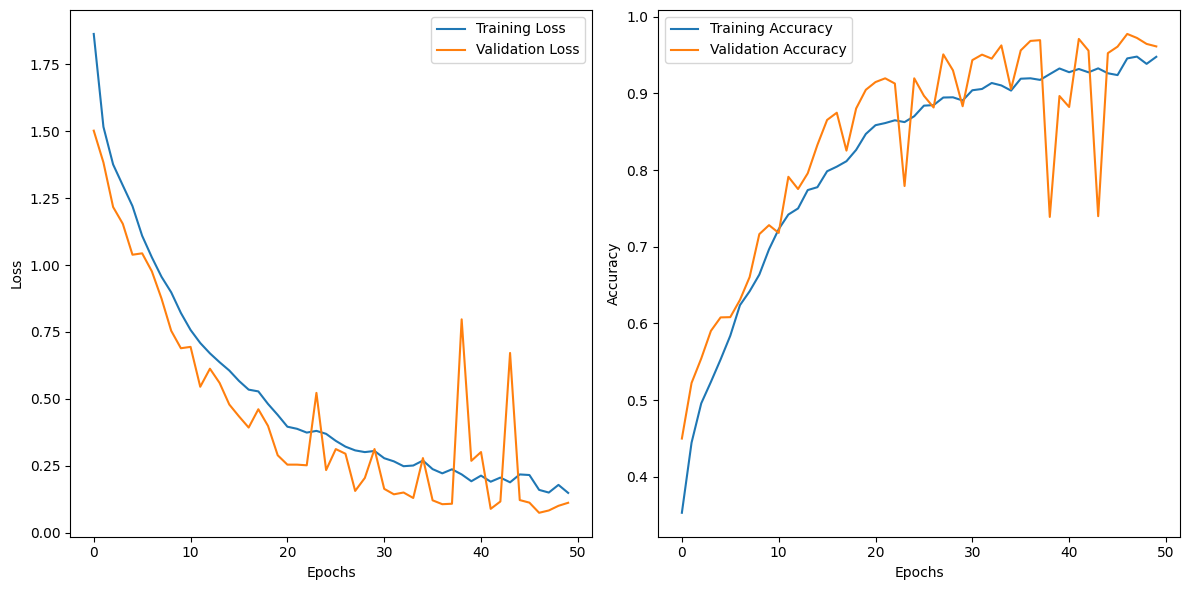

In [8]:
# plot the loss and accuracy curves
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.tight_layout()
plt.show()

In [9]:
# Compute class weights
class_weights = compute_class_weight(class_weight='balanced',
                                     classes=np.unique(y_train_raw),
                                     y=y_train_raw)

class_weights_dict = dict(enumerate(class_weights))

41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step


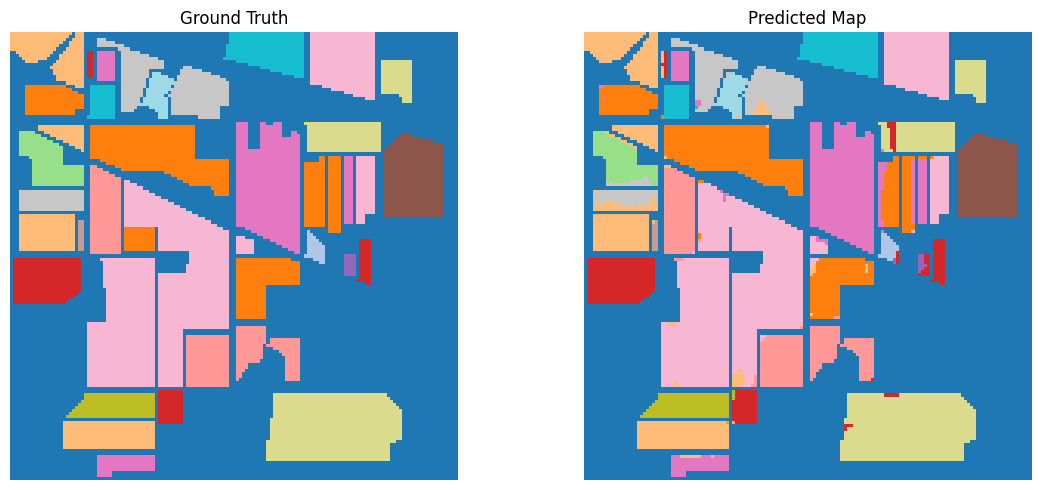

In [14]:
margin = patch_size // 2
height, width = labels.shape

# Pad the input data
padded_data = np.pad(
    normalized_data,
    ((margin, margin), (margin, margin), (0, 0)),
    mode='constant'
)

# Step 2: Collect patches and coordinates where labels exist
patch_list = []
coords = []

for r in range(height):
    for c in range(width):
        if labels[r, c] == 0:
            continue
        patch = padded_data[r:r + patch_size, c:c + patch_size]
        patch_list.append(patch)
        coords.append((r, c))

# Convert to NumPy array for batch prediction
patch_array = np.array(patch_list)  # Shape: (num_samples, patch_size, patch_size, bands)

# Step 3: Predict in batch
predictions = model.predict(patch_array, batch_size=256, verbose=1)
pred_classes = np.argmax(predictions, axis=1)

# Step 4: Create predicted map
pred_map = np.zeros((height, width))

for idx, (r, c) in enumerate(coords):
    pred_map[r, c] = pred_classes[idx] + 1  # Adjust for label starting at 1

# Step 5: Visualization function
def show_maps(gt, pred, title="Classification"):
    fig, axs = plt.subplots(1, 2, figsize=(12, 5))

    axs[0].imshow(gt, cmap='tab20')
    axs[0].set_title("Ground Truth")
    axs[0].axis('off')

    axs[1].imshow(pred, cmap='tab20')
    axs[1].set_title(title)
    axs[1].axis('off')

    plt.tight_layout()
    plt.show()

# Show results
show_maps(labels, pred_map, title="Predicted Map")

In [11]:
# Predict on the test set
y_pred_probs = model.predict(X_test)
y_pred_raw = np.argmax(y_pred_probs, axis=1)
y_true_raw = np.argmax(y_test, axis=1)

# Compute metrics
oa = accuracy_score(y_true_raw, y_pred_raw)  # Overall Accuracy
kappa = cohen_kappa_score(y_true_raw, y_pred_raw)  # Kappa coefficient
f1_macro = f1_score(y_true_raw, y_pred_raw, average='macro')  # Macro F1
precision_macro = precision_score(y_true_raw, y_pred_raw, average='macro')
recall_macro = recall_score(y_true_raw, y_pred_raw, average='macro')

print("\n Classification Report:")
print(classification_report(y_true_raw, y_pred_raw, digits=4))

print("Overall Accuracy     : {:.4f}".format(oa))
print("Cohen's Kappa       : {:.4f}".format(kappa))
print("Macro F1 Score       : {:.4f}".format(f1_macro))
print("Macro Precision      : {:.4f}".format(precision_macro))
print("Macro Recall         : {:.4f}".format(recall_macro))


97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step

 Classification Report:
              precision    recall  f1-score   support

           0     1.0000    0.8571    0.9231        14
           1     0.9922    0.8949    0.9410       428
           2     0.8732    0.9960    0.9306       249
           3     1.0000    0.8451    0.9160        71
           4     0.9051    0.9862    0.9439       145
           5     0.9907    0.9772    0.9839       219
           6     0.7500    0.3750    0.5000         8
           7     1.0000    1.0000    1.0000       143
           8     1.0000    1.0000    1.0000         6
           9     0.9236    0.9932    0.9571       292
          10     0.9693    0.9851    0.9771       737
          11     0.9112    0.8652    0.8876       178
          12     1.0000    1.0000    1.0000        61
          13     1.0000    0.9789    0.9894       380
          14     1.0000    1.0000    1.0000       116
          15     1.0000    0.8929    0.9434        28

    accuracy    

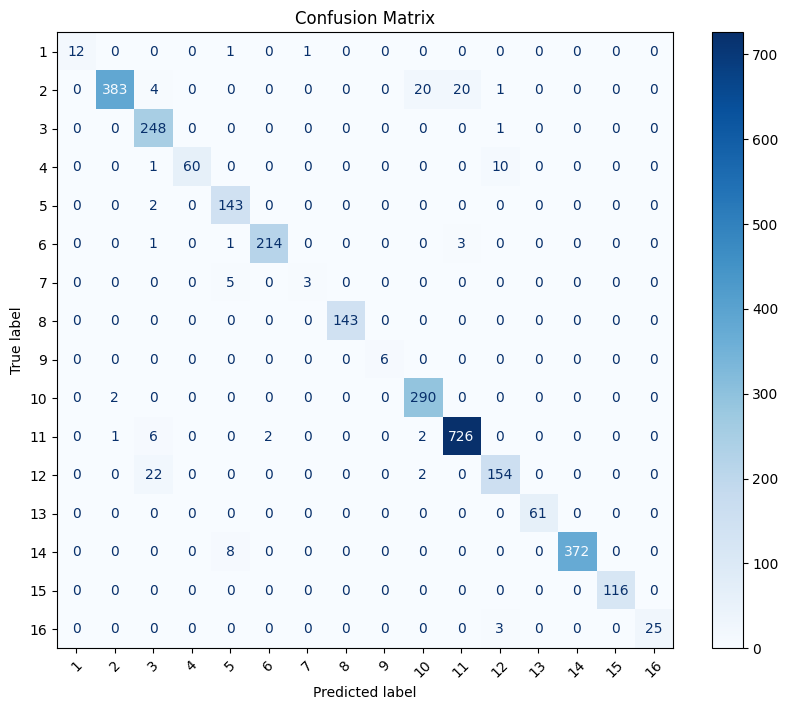

In [12]:
# Compute confusion matrix
cm = confusion_matrix(y_true_raw, y_pred_raw)

# Plot
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.arange(1, num_classes+1))
fig, ax = plt.subplots(figsize=(10, 8))
disp.plot(ax=ax, cmap='Blues', xticks_rotation=45)
plt.title("Confusion Matrix")
plt.show()